In [1]:
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy import create_engine
from database import Reactions

engine = create_engine('sqlite:///reactions2.db', echo = False)

Session = sessionmaker(bind=engine)
session = Session()

2022-12-10 20:00:27,618 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-10 20:00:27,619 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("reactions")
2022-12-10 20:00:27,619 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-10 20:00:27,620 INFO sqlalchemy.engine.Engine COMMIT


In [53]:
!pip show sqlalchemy

Name: SQLAlchemy
Version: 1.4.44
Summary: Database Abstraction Library
Home-page: https://www.sqlalchemy.org
Author: Mike Bayer
Author-email: mike_mp@zzzcomputing.com
License: MIT
Location: /opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages
Requires: 
Required-by: ord-schema


In [2]:
def getRxnFP(r, fp_type, summed, multipliers):
    if fp_type == "MACCS":
        rxnMatrix = np.zeros((5,167))
    else:
        rxnMatrix = np.zeros((5,2048))
    row = 0
    for k,m in zip(reagent_classes,multipliers):
        sm = getattr(r,k)
        if sm == "NONE":
            fp = np.zeros((1,))
        else:
            if k == "solvent":
                mol = Chem.MolFromSmiles(solv_map[sm])
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
                if "%" in sm:
                    s2 = sm.split("_")[1]
                    mol2 = Chem.MolFromSmiles(solv_map[s2])
                    fp2 = np.zeros((1,))
                    if fp_type == "MACCS":
                        DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp2)
                    else:
                        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp2)

                    fp = np.add(fp,fp2)
            else:
                mol = Chem.MolFromSmiles(sm)
                fp = np.zeros((1,))
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
        fp = fp*m
        rxnMatrix[row,:] = fp
        row = row + 1
    if summed:
        return np.sum(rxnMatrix, axis=0)
    else:
        return rxnMatrix

In [45]:
r = session.query(Reactions).all()
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

class_reagents = {k:[] for k in reagent_classes}

yields = []
index_split_by_class = {k:[] for k in reagent_classes}
rxnfps = []
yield_group = []
multipliers = [1, 1, 3, 1, 1]
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    for j in reagent_classes:
        if j=="solvent":
            mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
            sm = solv_map[getattr(k,j)]
        else:
            mol = Chem.MolFromSmiles(getattr(k,j))
            sm = getattr(k,j)
        if sm not in class_reagents[j]:
            class_reagents[j].append(sm)
        
        index_split_by_class[j].append(class_reagents[j].index(sm))
    n = k.group
    if n == "0":
        yield_group.append(0)
    elif n == "low":
        yield_group.append(1)
    elif n == "med":
        yield_group.append(2)
    else:
        yield_group.append(3)

    yields.append(float(k.output_value))
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)

In [46]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from sklearn_som.som import SOM

rxnfps = np.array(rxnfps)

X_PCA_RFP = PCA(n_components=2).fit_transform(rxnfps)
X_TSNE_RFP = TSNE(n_components=2, n_jobs=-1, random_state=1).fit_transform(rxnfps)
X_UMAP_RFP = umap.UMAP(n_components=2, n_jobs=-1, random_state=1).fit_transform(rxnfps)
X_SOM_TSNE_RFP = TSNE(n_components=2, n_jobs=-1, random_state=1).fit_transform(SOM(m=17, n=1, dim=2048).fit_transform(rxnfps))
X_SOM_RFP = SOM(m=2, n=1, dim=2048).fit_transform(rxnfps)

/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


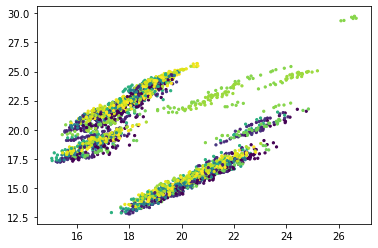

In [47]:
import matplotlib.pyplot as plt
plt.scatter(X_SOM_RFP[:,0], X_SOM_RFP[:,1], s=5, c=index_split_by_class["catalyst_smiles"])

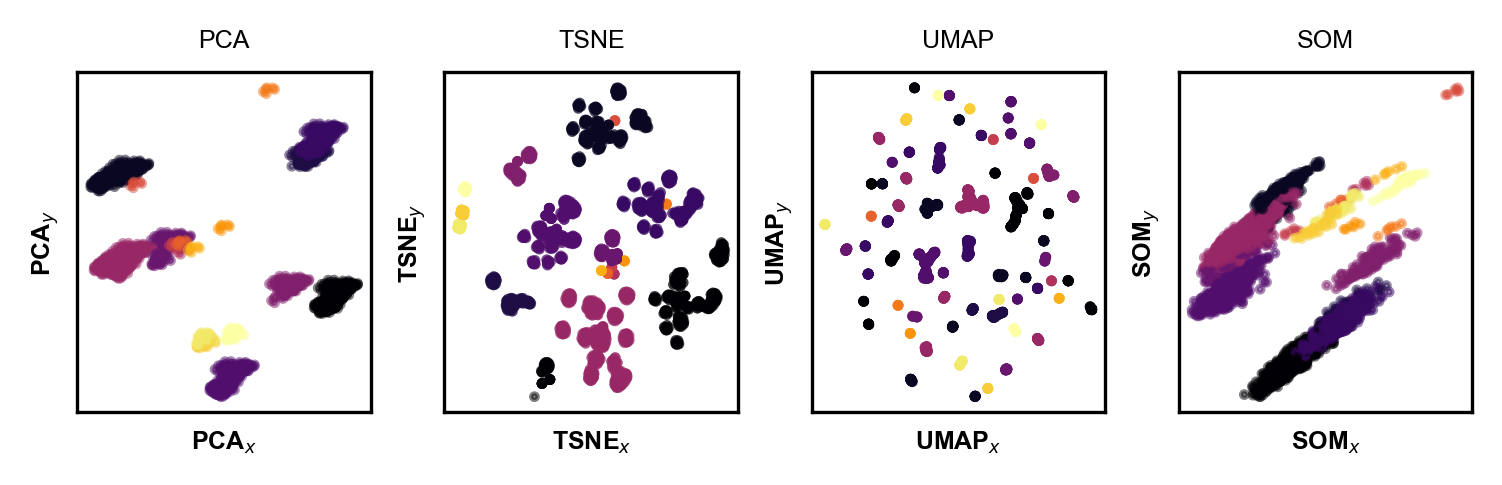

In [48]:


fig, ax = plt.subplots(1,4, figsize=(6, 1.5), dpi=300)
ax[0].scatter(X_PCA_RFP[:,0], X_PCA_RFP[:,1], cmap='inferno', c=index_split_by_class["catalyst_smiles"], alpha=.5, marker='.',s=10)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("PCA", fontfamily="arial", fontsize=6)
ax[0].set_xlabel("PCA$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
ax[0].set_ylabel("PCA$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[1].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["catalyst_smiles"], alpha=.5, marker='.',s=10)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("TSNE", fontfamily="arial", fontsize=6)
ax[1].set_xlabel("TSNE$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
ax[1].set_ylabel("TSNE$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[2].scatter(X_UMAP_RFP[:,0], X_UMAP_RFP[:,1], cmap='inferno', c=index_split_by_class["catalyst_smiles"], alpha=.5, marker='.',s=10)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title("UMAP", fontfamily="arial", fontsize=6)
ax[2].set_xlabel("UMAP$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
ax[2].set_ylabel("UMAP$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[3].scatter(X_SOM_RFP[:,0], X_SOM_RFP[:,1], cmap='inferno', c=index_split_by_class["catalyst_smiles"], alpha=.5, marker='.',s=10)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_title("SOM", fontfamily="arial", fontsize=6)
ax[3].set_xlabel("SOM$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
ax[3].set_ylabel("SOM$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

# plt.tight_layout()
plt.subplots_adjust(wspace=.25, hspace=.25)

plt.savefig(f'SI2C.png', dpi=300, bbox_inches='tight',pad_inches=0.01)

    # break